In [1]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import json
from typing import Optional
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn

In [3]:
from transformers import ElectraModel, ElectraPreTrainedModel, ElectraTokenizerFast as ElectraTokenizer, AdamW
from transformers.models.electra.modeling_electra import ElectraClassificationHead
# from transformers.utils.dummy_pt_objects import ElectraPreTrainedModel
from transformers import pipeline

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
%load_ext watermark

In [6]:
%watermark --iversions

json             : 2.0.9
seaborn          : 0.11.2
pytorch_lightning: 1.6.4
matplotlib       : 3.4.3
pandas           : 1.4.3
torch            : 1.10.0a0+0aef44c



In [7]:
pl.seed_everything(42)

Global seed set to 42


42

In [8]:
MODEL_NAME = "google/electra-base-discriminator"

In [9]:
if not os.path.exists('data'):
    !mkdir data
    !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
    !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
    !wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
    print('Download data set from link')
    pass
else:
    print('Data is present !!!')

Data is present !!!


In [10]:
file_paths = Path("data").glob("*.csv")

dfs = []
for file in file_paths:
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs)
df.created_utc = pd.to_datetime(df.created_utc, unit='s')
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,2019-01-15 05:15:35,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,2019-01-18 02:06:58,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,2019-01-03 02:27:40,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,2019-01-29 22:17:11,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,2019-01-14 20:17:01,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.shape

(211225, 37)

In [12]:
df.groupby("id").head(1).shape

(58011, 37)

In [13]:
emotion_categories = df.columns[9:]
emotion_categories

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [14]:
row = df.iloc[10]
sample_ratings = df[df.id == row.id]
sample_ratings

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
10,That’s terrible; I would be devastated. You ha...,eehquwb,[deleted],Divorce,t3_ahnqu3,t1_eeh6naq,2019-01-20 01:55:08,61,False,0,...,0,0,1,0,0,0,0,0,0,0
13987,That’s terrible; I would be devastated. You ha...,eehquwb,[deleted],Divorce,t3_ahnqu3,t1_eeh6naq,2019-01-20 01:55:08,37,False,0,...,0,0,1,0,0,0,0,0,0,0
19184,That’s terrible; I would be devastated. You ha...,eehquwb,[deleted],Divorce,t3_ahnqu3,t1_eeh6naq,2019-01-20 01:55:08,4,False,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
ratings = sample_ratings[emotion_categories]
ratings = ratings.columns[ratings.sum(axis=0) > 0]
ratings = ", ".join(ratings)
ratings

'approval, caring, disgust, optimism, sadness'

In [16]:
print(f"text     ::   {row.text}")
print(f"emotions ::   {ratings}")

text     ::   That’s terrible; I would be devastated. You had to get out of there though. I’m thinking of you.
emotions ::   approval, caring, disgust, optimism, sadness


In [17]:
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [18]:
encoding = tokenizer(row.text)
encoding

{'input_ids': [101, 2008, 1521, 1055, 6659, 1025, 1045, 2052, 2022, 13879, 1012, 2017, 2018, 2000, 2131, 2041, 1997, 2045, 2295, 1012, 1045, 1521, 1049, 3241, 1997, 2017, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
print(f"Text      :: {row.text}")
print(f"Tokens    :: {encoding.tokens()}")
print(f"Token IDs :: {encoding['input_ids']}")

Text      :: That’s terrible; I would be devastated. You had to get out of there though. I’m thinking of you.
Tokens    :: ['[CLS]', 'that', '’', 's', 'terrible', ';', 'i', 'would', 'be', 'devastated', '.', 'you', 'had', 'to', 'get', 'out', 'of', 'there', 'though', '.', 'i', '’', 'm', 'thinking', 'of', 'you', '.', '[SEP]']
Token IDs :: [101, 2008, 1521, 1055, 6659, 1025, 1045, 2052, 2022, 13879, 1012, 2017, 2018, 2000, 2131, 2041, 1997, 2045, 2295, 1012, 1045, 1521, 1049, 3241, 1997, 2017, 1012, 102]


In [20]:
token_lens = []

texts = df.groupby("id").head(1).text

for text in tqdm(texts):
    encoding = tokenizer(text)
    token_lens.append(len(encoding.tokens()))

100%|██████████| 58011/58011 [00:08<00:00, 6545.38it/s]


In [21]:
pd.Series(token_lens).value_counts().sort_index(ascending=False)[:10]

316    1
115    1
82     1
63     1
57     1
55     1
54     1
53     1
52     2
51     1
dtype: int64

Text(0.5, 0, 'Token count')

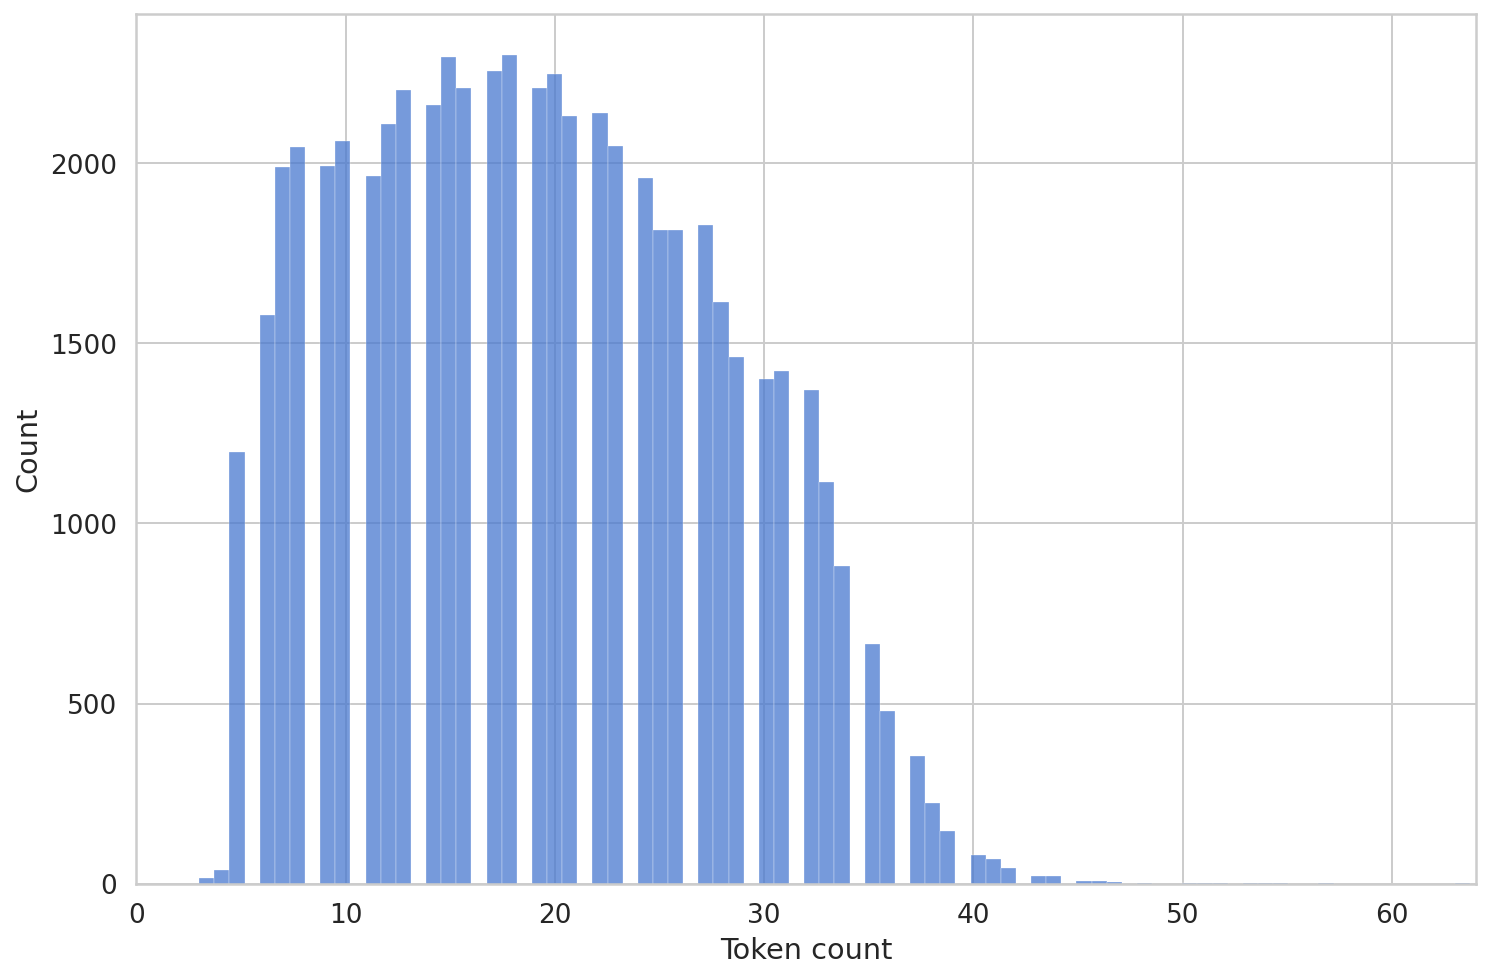

In [22]:
sns.histplot(token_lens)
plt.xlim(0,64)
plt.xlabel("Token count")

In [23]:
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,2019-01-15 05:15:35,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,2019-01-18 02:06:58,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,2019-01-03 02:27:40,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,2019-01-29 22:17:11,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,2019-01-14 20:17:01,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
texts = []
emotions = []

for comment_id, group in df.groupby("id"):
    texts.append(group.iloc[0].text)
    emotions.append(group[emotion_categories].sum(axis=0).argmax())

In [25]:
text_df = pd.DataFrame({"text": texts, "emotion": emotions})
text_df.head()

,text,emotion
0,Fast as [NAME] will carry me. Seriously uptown...,4
1,You blew it. They played you like a fiddle.,27
2,TL;DR No more Superbowls for [NAME]. Get ready...,9
3,So much time saved. Not.,7
4,Emotes have a ridiculous amount of effort put ...,27


In [26]:
EMOJI_MAP = {
    'admiration': '👏',
    'amusement': '😂',
    'anger': '😡',
    'annoyance': '😒',
    'approval': '👍',
    'caring': '🤗',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😍',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤮',
    'embarrassment': '😳',
    'excitement': '🤩',
    'fear': '😨',
    'gratitude': '🙏',
    'grief': '😢',
    'joy': '😃',
    'love': '❤️',
    'nervousness': '😬',
    'optimism': '🤞',
    'pride': '😌',
    'realization': '💡',
    'relief': '😅',
    'remorse': '',
    'sadness': '😞',
    'surprise': '😲',
    'neutral': '',
}


In [27]:
text_df["emoji"] = text_df.emotion.map(lambda x: emotion_categories[x]).map(lambda x: EMOJI_MAP[x])

In [28]:
text_df.head()

,text,emotion,emoji
0,Fast as [NAME] will carry me. Seriously uptown...,4,👍
1,You blew it. They played you like a fiddle.,27,
2,TL;DR No more Superbowls for [NAME]. Get ready...,9,😞
3,So much time saved. Not.,7,🤔
4,Emotes have a ridiculous amount of effort put ...,27,


In [29]:
class EmotionDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: ElectraTokenizer):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = tokenizer(
            row.text,
            max_length=64,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(row.emotion)
        }

In [30]:
ds = EmotionDataset(text_df, tokenizer)
print(len(ds) == len(text_df))

True


In [31]:
for item in ds:
    print(item["input_ids"][:10])
    print(item["label"])
    break

tensor([ 101, 3435, 2004, 1031, 2171, 1033, 2097, 4287, 2033, 1012])
tensor(4)


In [32]:
class EmotionDataModule(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, tokenizer: ElectraTokenizer, batch_size: int):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.batch_size = batch_size
    
    def setup(self, stage: Optional[str] = None):
        self.train_df, test_df = train_test_split(self.data, test_size=0.2)
        self.val_df, self.test_df = train_test_split(test_df, test_size=0.5)
    
    def train_dataloader(self):
        return DataLoader(
            dataset=EmotionDataset(self.train_df, self.tokenizer),
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=True
        )
        
    def val_dataloader(self):
        return DataLoader(
            dataset=EmotionDataset(self.val_df, self.tokenizer),
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=False
        )
    
    def test_dataloader(self):
        return DataLoader(
            dataset=EmotionDataset(self.test_df, self.tokenizer),
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=False
        )
    

In [33]:
data_module = EmotionDataModule(text_df, tokenizer, batch_size=32)

In [34]:
data_module.setup()
for batch in data_module.train_dataloader():
    print(len(batch))
    
    print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['label'].shape)
    break

3
torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([32])


In [35]:
fill_mask = pipeline(
    "fill-mask",
    model="google/electra-base-generator",
    tokenizer="google/electra-base-generator",
    top_k=3
)

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [36]:
text = f"I am not superstitious, but I am a little [MASK]."

print(json.dumps(fill_mask(text), indent=4))

[
    {
        "score": 0.0404188446700573,
        "token": 15743,
        "token_str": "naive",
        "sequence": "i am not superstitious, but i am a little naive."
    },
    {
        "score": 0.031200753524899483,
        "token": 2367,
        "token_str": "different",
        "sequence": "i am not superstitious, but i am a little different."
    },
    {
        "score": 0.025371136143803596,
        "token": 15818,
        "token_str": "arrogant",
        "sequence": "i am not superstitious, but i am a little arrogant."
    }
]


In [37]:
text = f"Would I rather be feared or loved? Easy. I want people to be afraid of how much they [MASK] me."

print(json.dumps(fill_mask(text), indent=4))

[
    {
        "score": 0.534376859664917,
        "token": 2293,
        "token_str": "love",
        "sequence": "would i rather be feared or loved? easy. i want people to be afraid of how much they love me."
    },
    {
        "score": 0.1514541357755661,
        "token": 5223,
        "token_str": "hate",
        "sequence": "would i rather be feared or loved? easy. i want people to be afraid of how much they hate me."
    },
    {
        "score": 0.03171038255095482,
        "token": 2342,
        "token_str": "need",
        "sequence": "would i rather be feared or loved? easy. i want people to be afraid of how much they need me."
    }
]


In [38]:
from transformers import ElectraForPreTraining
model = ElectraForPreTraining.from_pretrained("google/electra-small-discriminator")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

In [39]:
text = f"I am not superstitious, but I am a little yoga."

encoding = tokenizer(text, return_tensors="pt")
outputs = model(**encoding)

In [40]:
outputs.logits

tensor([[-10.4003,  -7.1694,  -6.2349,  -3.8967,  -8.1406,  -8.0844,  -6.7816,
          -4.8575,  -3.5403,  -4.6780,  -1.1182,  -2.4072,  -1.5506,  -0.0226,
          -5.5492, -10.4025]], grad_fn=<SqueezeBackward1>)

In [41]:
def show_detections(tokens, logits):
    replaced_token_index = torch.argmax(logits, dim=-1).item()
    special_tokens = set(tokenizer.special_tokens_map.values())
    
    for i, token in enumerate(tokens):
        if token in special_tokens:
            continue
        if i == replaced_token_index:
            print(f"{token} -> replaced")
        else:
            print(f"{token} -> original")

In [42]:
show_detections(encoding.tokens(), outputs.logits)

i -> original
am -> original
not -> original
super -> original
##sti -> original
##tious -> original
, -> original
but -> original
i -> original
am -> original
a -> original
little -> original
yoga -> replaced
. -> original


In [43]:
text = f"The quick brown egg jumps over the lazy dog"

encoding = tokenizer(text, return_tensors="pt")
outputs = model(**encoding)

show_detections(encoding.tokens(), outputs.logits)

the -> original
quick -> original
brown -> original
egg -> replaced
jumps -> original
over -> original
the -> original
lazy -> original
dog -> original


### Emotion Classifier

In [44]:
class ElectraClassifier(ElectraPreTrainedModel):
    
    def __init__(self, config):
        super().__init__(config)
        self.n_classes = config.num_labels
        self.config = config
        self.electra = ElectraModel(config)
        self.classifier = ElectraClassificationHead(config)
        
        self.init_weights()
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None
    ):
        discriminator_hidden_states =  self.electra(input_ids, attention_mask)
        sequence_output = discriminator_hidden_states[0]
        logits = self.classifier(sequence_output)
        return logits

In [45]:
class EmotionClassifier(pl.LightningModule):
    def __init__(self, n_classes, learning_rate: Optional[float] = None):
        super().__init__()
        self.n_classes = n_classes
        self.classifier = ElectraClassifier.from_pretrained(
            "google/electra-small-discriminator",
            num_labels=self.n_classes
        )
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
    
    def forward(self, input_ids, attention_mask):
        return self.classifier(input_ids, attention_mask)
    
    def run_step(self, batch, stage):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label'].long()
        logits = self(input_ids, attention_mask)
        
        loss = self.criterion(logits, labels)
        self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
        
    def training_step(self, batch, batch_idx):
        return self.run_step(batch, "train")
        
    def validation_step(self, batch, batch_idx):
        return self.run_step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.run_step(batch, "test")
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

In [46]:
emotion_categories

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [47]:
MAX_LEARNING_RATE = 1e-2
BATCH_SIZE = 512
TRAINING_STEPS = 650

data_module = EmotionDataModule(
    text_df,
    tokenizer,
    batch_size=BATCH_SIZE
)

model = EmotionClassifier(
    n_classes=len(emotion_categories),
    learning_rate=MAX_LEARNING_RATE
)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_

In [48]:
trainer = pl.Trainer(gpus=1)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
lr_finder = trainer.tuner.lr_find(model, data_module, max_lr=MAX_LEARNING_RATE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /notebooks/pytorch-mini-study/go-emotions/.lr_find_ba5e017c-34cf-40e7-b576-1361ead43e3e.ckpt


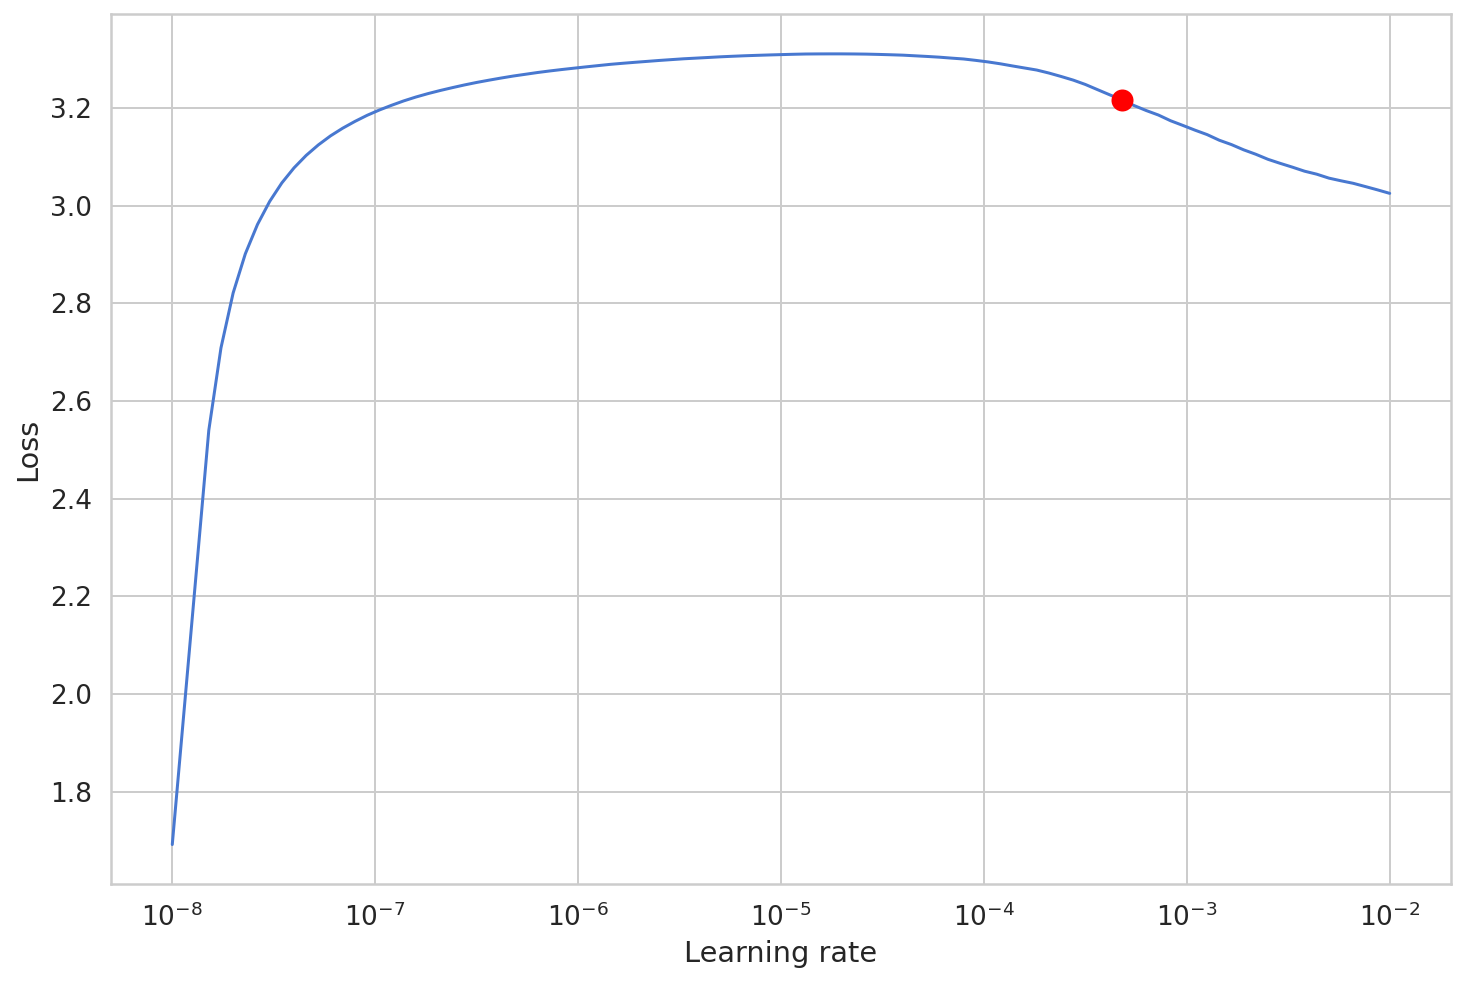

In [50]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [51]:
new_lr = lr_finder.suggestion()
lr_finder.suggestion()

0.00047863009232263854

In [52]:
model.learning_rate = new_lr

In [53]:
%load_ext tensorboard

In [54]:
experiments_dir = "experiments"

model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.2f}",
    save_last=True,
    save_top_k=3,
    monitor="val_loss_epoch",
    mode="min"
)

logger = TensorBoardLogger(save_dir=experiments_dir, name="emotion_classifier")

In [55]:
%tensorboard --logdir experiments

In [56]:
trainer = pl.Trainer(
    default_root_dir=experiments_dir,
    gpus=1,
    max_steps=TRAINING_STEPS,
    precision=16,
    val_check_interval=40,
    callbacks=[
        model_checkpoint
    ],
    logger=logger
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(model, data_module)

Missing logger folder: experiments/emotion_classifier
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | ElectraClassifier | 13.6 M
1 | criterion  | CrossEntropyLoss  | 0     
-------------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
27.112    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [58]:
trainer.test(datamodule=data_module)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at experiments/emotion_classifier/version_0/checkpoints/epoch=3-step=353-val_loss=1.66.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at experiments/emotion_classifier/version_0/checkpoints/epoch=3-step=353-val_loss=1.66.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    1.3799360990524292     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.3799360990524292}]

In [59]:
model.classifier.save_pretrained("emotion_classifier")

In [61]:
!head emotion_classifier/config.json

{
  "_name_or_path": "google/electra-small-discriminator",
  "architectures": [
    "ElectraClassifier"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
